# **Analysis of big data job requirements based on K-means text clustering in China**

## **Introduction**

An analysis of job requirements related to big data in China using K-means text clustering will be conducted. The dataset required for this analysis can be obtained from [https://doi.org/10.1371/journal.pone.0255419](https://doi.org/10.1371/journal.pone.0255419). For more detailed information about the dataset, please refer to the corresponding article at [https://doi.org/10.1371/journal.pone.0255419](https://doi.org/10.1371/journal.pone.0255419). Prior to applying K-means text clustering, it is necessary to preprocess the data. Additionally, after clustering the data, you will need to visualise the clustered data in order to perform data analysis on the resulting cluster groups.


# **Global Constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BDC Datasets"
DATASET_URL = "https://ndownloader.figstatic.com/files/29057940"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

RANDOM_SEED = 42 # for reproducibility
MAX_K_CLUSTERS = 10 # max number of clusters

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [ ]:
!pip install -q pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install -q pyspark==3.2.1
!pip install -q -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install -q openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 122531 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u372-ga~us1-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u372-ga~us1-0ubuntu1~20.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u372-ga~us1-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u372-ga~us1-0ubuntu1~20.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1) ...
Setting up openjdk-8-jre-headless:amd64 (8u372-ga~us1-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/

## **2.** Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '10G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **5.** Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.app.startTime', '1684522822106'),
 ('spark.driver.port', '34427'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '10G'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.ut

# **Data Acquisition**

Download the dataset file from URL directly to our Google Drive.

In [ ]:
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200:
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size):
        if block:
          file.write(block)

In [ ]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://ndownloader.figstatic.com/files/29057940 ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/BDC Datasets/29057940


### Read dataset file into a Spark Dataframe

In [ ]:
advert_df = pd.read_excel(io=GDRIVE_DATASET_FILE, engine='openpyxl')
advert_df = spark.createDataFrame(advert_df)
advert_df.cache();

### Check the shape of the loaded dataset, i.e., the numbers of rows and columns [1 Mark]

In [ ]:

num_rows = advert_df.count()
num_cols = len(advert_df.columns)
print(f"The shape of the dataset is {num_rows} rows by {num_cols} columns")

The shape of the dataset is 16551 rows by 7 columns


### Print out the schema of the loaded dataset [1 Mark]

In [ ]:

advert_df.printSchema()

root
 |-- Job title: string (nullable = true)
 |-- Salary range: string (nullable = true)
 |-- Location 1: string (nullable = true)
 |-- Location 2: string (nullable = true)
 |-- Experience requirement: string (nullable = true)
 |-- Education requirements: string (nullable = true)
 |-- Job requirements: string (nullable = true)



### Display the first 10 rows of the dataset [1 Mark]

In [ ]:

advert_df.show(10)

+--------------------+--------------------+----------+--------------------+----------------------+----------------------+----------------+
|           Job title|        Salary range|Location 1|          Location 2|Experience requirement|Education requirements|Job requirements|
+--------------------+--------------------+----------+--------------------+----------------------+----------------------+----------------+
|Internet data sal...|    15,000 to 20,000|   Beijing|             Beiyuan|             3-5 years|        Junior college|       Full time|
|Internet data sal...|    15,000 to 20,000|   Beijing|             Beiyuan|             3-5 years|        Junior college|       Full time|
|Research and Deve...|    15,000 to 20,000|   Beijing|western informal ...|             3-5 years|                master|       Full time|
|Procurement data ...|7 thousand-12 tho...|   Beijing|  Gaobeidian village|             1-3 years|        Junior college|       Full time|
|Product Manager (...|15 th

### Count the number of records with any missing value (i.e., `NULL`, `NAN`, etc. ) along all columns [2 Marks]

In [ ]:

advert_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in advert_df.columns]
   ).show()

+---------+------------+----------+----------+----------------------+----------------------+----------------+
|Job title|Salary range|Location 1|Location 2|Experience requirement|Education requirements|Job requirements|
+---------+------------+----------+----------+----------------------+----------------------+----------------+
|        0|           0|         0|      1073|                     0|                     0|               0|
+---------+------------+----------+----------+----------------------+----------------------+----------------+



### Show the corresponding 10 `NULL` and `NAN` entry/ies [1 Mark]

In [ ]:

advert_df.filter((isnan(col("Location 2")) | col("Location 2").isNull())).show(10)

+--------------------+--------------------+----------+----------+----------------------+----------------------+--------------------+
|           Job title|        Salary range|Location 1|Location 2|Experience requirement|Education requirements|    Job requirements|
+--------------------+--------------------+----------+----------+----------------------+----------------------+--------------------+
|     camera operator|4 thousand -6 tho...|   Xi ' an|       NaN|             Ring Road|             1-3 years|      Junior college|
|    Data entry clerk|     2.8 -4 thousand|   Xi ' an|       NaN|           Zhangjiabao|             1-3 years|Technical seconda...|
|Quality control s...|4 thousand -7 tho...|   Xi ' an|       NaN|           Xishao gate|  Experience is unl...|      Junior college|
|Data Processing S...|4 thousand -6 tho...|   Xi ' an|       NaN|                Xiguan|  Experience is unl...|      Junior college|
|Data entry specia...|6 thousand -8 tho...|   Xi ' an|       NaN|    

### Remove `NULL` and `NAN` entry/ies  [2 Marks]

In [ ]:


def to_null(c):
    return when(~(isnan(col(c))), col(c))

advert_df=advert_df.select([to_null(c).alias(c) for c in advert_df.columns]).na.drop()

print(f"The shape of the dataset is {advert_df.count()} rows by {len(advert_df.columns)} columns")


The shape of the dataset is 15478 rows by 7 columns


### Count the number of duplicate job adverts (if any) [2 Marks]

In [ ]:

duplicates = advert_df.count() - advert_df.dropDuplicates().count()
print(f"The total number of duplicate job adverts is {duplicates} out of {advert_df.count()} ")


The total number of duplicate job adverts is 1013 out of 15478 


### Display all duplicate job adverts  [2 Marks]

In [ ]:

duplicate_columns = advert_df.columns

advert_df.groupBy(duplicate_columns).count().sort("count",ascending=False).filter(col('count')>1).show(advert_df.count())

+----------------------+--------------------+--------------------+--------------------+----------------------+----------------------+-------------------+-----+
|             Job title|        Salary range|          Location 1|          Location 2|Experience requirement|Education requirements|   Job requirements|count|
+----------------------+--------------------+--------------------+--------------------+----------------------+----------------------+-------------------+-----+
|  The data entry st...|4 thousand -6 tho...|Xihu District, Ha...|           West lake|  Experience is unl...|           High school|          Full time|    7|
|  Data communicatio...|4 thousand -8 tho...|           Changchun|               Linhe|             1-3 years|        Junior college|          Full time|    6|
|  Financial data an...|6 thousand -8 tho...|              Dalian|      Zhongshan Road|             1-3 years|  Undergraduate course|          Full time|    5|
|  Japanese data pro...|Two thousand-fou

### Remove duplicate job adverts  [2 Marks]

In [ ]:

advert_df = advert_df.dropDuplicates(advert_df.columns)
unique_count = advert_df.distinct().count()
print(f"The total number of unique job adverts is: {unique_count}")

The total number of unique job adverts is: 14465


### Combine the columns `Location 1` and `Location 2` as `Location`  [1 Mark]

In [ ]:

advert_df = advert_df.withColumn("Location",concat_ws(' ',col('Location 1'),col('Location 2')))
advert_df = advert_df.drop('Location 1').drop('Location 2')
advert_df = advert_df.select(advert_df.columns[:2]+[advert_df.columns[-1]]+advert_df.columns[2:-1])
advert_df.show(10,truncate=False)

+------------------------------------------------------------------------+-----------------------+-------------------------------------+-----------------------+----------------------+----------------+
|Job title                                                               |Salary range           |Location                             |Experience requirement |Education requirements|Job requirements|
+------------------------------------------------------------------------+-----------------------+-------------------------------------+-----------------------+----------------------+----------------+
|Data warehouse development engineer                                     |Negotiable             |Beijing Chaoyang road                |3-5 years              |Undergraduate course  |Full time       |
|Data visualization engineer assistant (can practice for 5K)             |6 thousand -8 thousand |Beijing Baishiqiao                   |Experience is unlimited|Junior college        |Full time    

### Normalise the data in `Salary range` [10 Marks]

Normalise the records in `Salary range` column according the following definition. For a salary record in the range of $[A,B]$, compute the average $C = \frac{A+B}{2}$ and use the following mapping for the new value of the record:

* If $0 \leq C < 4000$, then `record_value = '(A)<4K'`
* If $4000 \leq C < 8000$, then `record_value = '(B)[4K,8K)'`
* If $8000 \leq C < 12000$, then `record_value = '(C)[8K,12K)'`
* If $12000 \leq C < 16000$, then `record_value = '(D)[12K,16K)'`
* If $16000 \leq C < 20000$, then `record_value = '(E)[16K,20K)'`
* If $C \geq 20000$, then `record_value = '(F)>20K'`
* Otherwise, `record_value = '(G)Interview'`

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [ ]:

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StructType, StructField
import re

def normalise_salary_range(A,B):
  C = (A + B) / 2
  if C>= 0 and C < 4000:
      return "(A)<4K"
  elif C>=4000 and C < 8000:
      return "(B)[4K-8K)"
  elif C>=8000 and C < 12000:
      return "(C)[8K-12K)"
  elif C>=12000 and C < 16000:
      return "(D)[12K-16K)"
  elif C>=16000 and C < 20000:
      return "(E)[16K-20K)"
  elif C>=20000:
      return "(F)>=20K"
  else :
      return "(G)Interview"


normalise_salary_range_udf = udf(normalise_salary_range, StringType())

def extract_salary_range(input_str):
    lower = float(-1)
    upper = float(-1)
    input_str = input_str.replace(",", "") # remove commas
    #regex to select lower and upper bound for strings containing a '-' and (optionally) the word 'thousand' or a 'k' or a decimal
    match = re.match(r"\$?(\d+(?:\.\d+)?)(?:k)?\s*(?:thousand)?\s*-\s*\$?(\d+(?:\.\d+)?)(?:k)?\s*(?:thousand)?", input_str)

    if match:
        lower = float(match.group(1))
        upper = float(match.group(2))

        if (float(match.group(1)) < 1000):
            lower *= 1000
            upper *= 1000
    else:
      #regex to select bounds for string containing the word 'to'
        match = re.match(r"(\d+)\s*(?:thousand)?\s*to\s*(\d+)\s*(?:thousand)?", input_str)
        if match:
            lower = float(match.group(1))
            upper = float(match.group(2))
            if (float(match.group(1)) < 1000):
              lower *= 1000
              upper *= 1000
        else:
          #convert words to numbers ie. "Two thousand-four thousand"
          if  len(input_str.split('-'))>1:

              range_parts = input_str.split('-')
              lower_limit = range_parts[0].strip().lower()
              upper_limit = range_parts[1].strip().lower()

              number_map = {
                  'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
                  'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9,
                  'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
                  'fifteen': 15, 'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19,
                  'twenty': 20, 'thirty': 30, 'forty': 40, 'fifty': 50, 'sixty': 60,
                  'seventy': 70, 'eighty': 80, 'ninety': 90
              }

              def convert_word_to_number(word):
                  if word in number_map:
                      return number_map[word]
                  else:
                      return None

              lower_words = lower_limit.split()
              upper_words = upper_limit.split()

              lower = 0.0
              upper = 0.0

              for word in lower_words:
                  number = convert_word_to_number(word)
                  if number is not None:
                      lower += number

              for word in upper_words:
                  number = convert_word_to_number(word)
                  if number is not None:
                      upper += number
              if upper < 1000:
                upper *= 1000
              if lower < 1000:
                lower *= 1000

    return (lower, upper)

# Register the function as a UDF
extract_salary_range_udf = udf(extract_salary_range, StructType([
    StructField("Lower", FloatType(), nullable=True),
    StructField("Upper", FloatType(), nullable=True)
]))

advert_df = advert_df.withColumn("Salary range", extract_salary_range_udf(col("Salary range")))
advert_df = advert_df.withColumn("Salary range", normalise_salary_range_udf(col('Salary range.Lower'), col("Salary range.Upper")))
advert_df.show(80)

+--------------------+------------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range|            Location|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|Beijing Chaoyang ...|             3-5 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K-8K)|  Beijing Baishiqiao|  Experience is unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K-16K)|  Beijing Drum tower|             3-5 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K-8K)|Wuhou District, C...|          Under 1 year|        Junior college|       Full time|
|      Data assistant|  (B)[4K-8K)|Chengdu high-tech...|             1-3 years|  Undergraduate course|       Full time|
|Data product manager|    (F)>=20K|Wuhou

### Normalise the data in `Location` as `Location` and `Tier`  [5 Marks]

Normalise the records in `Location` column according the following definition. If the string value of the record contains any of the cities in the following dictionary, set the `Location` and the corresponding `Tier` for the record accordingly. If the string value does not contain any of the cities in the dictionary, then the corresponding record must be dropped. You need to pay particular attention to the city `Xi'an` in the records during the normalisation process.

```
cities = dict()
cities["First-tier cities"] = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen"]

cities["New first-tier cities"] = ["Chengdu", "Hefei", "Hangzhou", "Nanjing",
                                    "Shenyang", "Tianjin", "Wuxi", "Wuhan",
                                    "Xi'an", "Changsha", "Zhengzhou", "Chongqing"]
                                    
cities["Others"] = ["Dalian", "Fuzhou", "Harbin", "Guiyang", "Jinan", "Ningbo",
                    "Xiamen", "Shijiazhuang", "Changchun"]
```

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [ ]:

from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

cities = dict()
cities["First-tier cities"] = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen"]

cities["New first-tier cities"] = ["Chengdu", "Hefei", "Hangzhou", "Nanjing",
                                    "Shenyang", "Tianjin", "Wuxi", "Wuhan",
                                    "Xi'an", "Changsha", "Zhengzhou", "Chongqing"]

cities["Others"] = ["Dalian", "Fuzhou", "Harbin", "Guiyang", "Jinan", "Ningbo",
                    "Xiamen", "Shijiazhuang", "Changchun"]

city_list = [city for item in cities.values() for city in item] #get cities in one list

def set_tier(location):
  #convert the location string to a list, exclude whitespace and non-word characters ie ','
  location_n = re.findall(r"\s*(\w+(?:\s*'\s*\w+)?)\s*", location)
  location_n = [word.replace(" ",'') for word in location_n]
  location_n = [word.replace(",",'') for word in location_n]
  location_n = [x.capitalize() for x in location_n]

  for word in location_n:
    if word in city_list:
      location_n = word
      break

  if location_n in cities["First-tier cities"]:
    return (location_n,"First-tier cities")
  elif location_n in cities["New first-tier cities"]:
    return (location_n,"New first-tier cities")
  elif location_n in cities["Others"]:
    return (location_n,"Others")
  return (location_n,None)

#make udf
set_tier_udf = udf(set_tier, StructType([
    StructField("location", StringType(), nullable=True),
    StructField("tier", StringType(), nullable=True)
]))

advert_df = advert_df.withColumn("temp", set_tier_udf(col("Location")))
advert_df = advert_df.withColumn("Location", col("temp.location"))
advert_df = advert_df.withColumn("Tier", col("temp.tier")).drop("temp")

advert_df = advert_df.na.drop(subset=['Tier'])
advert_df = advert_df.select(advert_df.columns[:3]+[advert_df.columns[-1]]+advert_df.columns[3:-1])
advert_df.show(80)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|             3-5 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K-8K)|  Beijing|   First-tier cities|  Experience is unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K-16K)|  Beijing|   First-tier cities|             3-5 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K-8K)|  Chengdu|New first-tier ci...|          Under 1 year|        Junior college|       Full time|
|      Data assistant|  (B)[4K-8K)|  Chengdu|New first-tier ci...|             1-3 years| 

### Check the shape of the dataset after normalisation, i.e., the numbers of rows and columns

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 14377 rows by 7 columns


### Normalise the data in `Experience requirement`  [5 Marks]

Normalise the records in `Experience` column according the following definition. For an experience requirement in the range of $[A,B]$, compute the average $C = \frac{A+B}{2}$ and use the following mapping for the new value of the record:

* If $C <= 3$, then `record_value = '(A)1-3 years'`
* If $C > 3$, then `record_value = '(B)More than 3 years'`
* Otherwise, `record_value = '(C)Experience unlimited'`

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [ ]:

def normalise_experience(experience):
  match = re.findall(r"\d+",experience)
  if (len(match)>1):
    average = (int(match[0])+int(match[1]))/2
  elif (len(match)==1):
    average = int(match[0])
  else:
    average = -1

  if average<=3 and average>=0:
    return '(A)1-3 years'
  elif average>3:
    return '(B)More than 3 years'

  return'(C)Experience unlimited'

normalise_experience_udf = udf(normalise_experience, StringType())
advert_df = advert_df.withColumn("Experience requirement", normalise_experience_udf(col("Experience requirement")))
advert_df.show(80)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|  (B)More than 3 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K-8K)|  Beijing|   First-tier cities|  (C)Experience unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K-16K)|  Beijing|   First-tier cities|  (B)More than 3 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K-8K)|  Chengdu|New first-tier ci...|          (A)1-3 years|        Junior college|       Full time|
|      Data assistant|  (B)[4K-8K)|  Chengdu|New first-tier ci...|          (A)1-3 years| 

### Normalise the data in `Education requirements`  [5 Marks]

Normalise the records in `Education requirements` column according the following dictionary.

```
education = dict()
education["(A)Primary Education"] = ["Junior high school and below"]
education["(B)Secondary Education"] = ["Technical secondary school/technical secondary school",
                                    "High school","Junior college"]
education["(C)Undergraduate"] = ["Undergraduate course"]
education["(D)Graduate"] = ["master", "Doctor"]
education["(E)Education Unlimited"] = ["Education is not limited"]
```

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [ ]:

education = dict()
education["(A)Primary Education"] = ["Junior high school and below"]
education["(B)Secondary Education"] = ["Technical secondary school/technical secondary school",
                                    "High school","Junior college"]
education["(C)Undergraduate"] = ["Undergraduate course"]
education["(D)Graduate"] = ["master", "Doctor"]
education["(E)Education Unlimited"] = ["Education is not limited"]

def normalise_education(education_val):
  if education_val in education["(A)Primary Education"]:
    return "(A)Primary Education"
  elif education_val in education["(B)Secondary Education"]:
    return "(B)Secondary Education"
  elif education_val in education["(C)Undergraduate"]:
    return "(C)Undergraduate"
  elif education_val in education["(D)Graduate"]:
    return "(D)Graduate"
  else :
    return "(E)Education Unlimited"

normalise_education_udf = udf(normalise_education, StringType())
advert_df = advert_df.withColumn("Education requirements",normalise_education_udf(col("Education requirements")))
advert_df.show(80)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|  (B)More than 3 years|      (C)Undergraduate|       Full time|
|Data visualizatio...|  (B)[4K-8K)|  Beijing|   First-tier cities|  (C)Experience unl...|  (B)Secondary Educ...|       Full time|
|Data Management C...|(D)[12K-16K)|  Beijing|   First-tier cities|  (B)More than 3 years|  (B)Secondary Educ...|       Full time|
|Data return visit...|  (B)[4K-8K)|  Chengdu|New first-tier ci...|          (A)1-3 years|  (B)Secondary Educ...|       Full time|
|      Data assistant|  (B)[4K-8K)|  Chengdu|New first-tier ci...|          (A)1-3 years| 

# **Data Preprocessing**

In this assignment, we are working with text data in the `Job title` column and our ultimate goal is to cluster job adverts into groups of coherent "topics" using one of the clustering algorithms we know (e.g., K-means). This is a specific task of a more general area, which is referred to as _natural language processing_ (NLP).

As **preliminary** steps of any NLP task, at least the following pipeline must be executed first:

- Text cleaning:
 - Case normalization (<code>lower</code>) -> convert all text to lower case;
 - Filter out _leading_ and _trailing_ whitespaces (<code>trim</code>);
 - Filter out punctuation symbols (<code>regexp_replace</code>);
 - Filter out any internal extra whitespace resulting from the step above (<code>regexp_replace</code> + <code>trim</code>).
- Tokenization (<code>Tokenizer</code>): splitting raw text into a list of individual _tokens_ (i.e., words), typically using whitespace as delimiter
- Stopwords removal (<code>StopWordsRemover</code>): removing so-called _stopwords_, namely words that do not contribute to the deeper meaning of the document like "the", "a", "me", etc.
- Stemming (<code>SnowballStemmer</code>): reducing each word to its root or base. For example "fishing", "fished", "fisher" all reduce to the stem "fish".

In [ ]:
def clean_text(df, column_name="Job title"):
    """
    This function takes the raw text data and apply a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `Job title (cleaned)` column as the results of the NLP preprocessing pipeline

    """
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer

    # Text preprocessing pipeline
    print("***** Text Preprocessing Pipeline *****\n")

    # 1. Text cleaning
    print("# 1. Text Cleaning\n")
    # 1.a Case normalization
    print("1.a Case normalization:")
    lower_case_news_df = df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", lower(col(column_name)).alias(column_name))
    lower_case_news_df.show(10)
    # 1.b Trimming
    print("1.b Trimming:")
    trimmed_news_df = lower_case_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", trim(col(column_name)).alias(column_name))
    trimmed_news_df.show(10)
    # 1.c Filter out punctuation symbols
    print("1.c Filter out punctuation:")
    no_punct_news_df = trimmed_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", (regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name))
    no_punct_news_df.show(10)
    # 1.d Filter out any internal extra whitespace
    print("1.d Filter out extra whitespaces:")
    cleaned_news_df = no_punct_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", trim(regexp_replace(col(column_name), " +", " ")).alias(column_name))
    cleaned_news_df.show(10)

    # 2. Tokenization (split text into tokens)
    print("# 2. Tokenization:")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)
    tokens_df.show(10)

    # 3. Stopwords removal
    print("# 3. Stopwords removal:")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
    terms_df.show(10)

    # 4. Stemming (Snowball stemmer)
    print("# 4. Stemming:")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))
    terms_stemmed_df.show(10)

    return terms_stemmed_df

In [ ]:
clean_advert_df = clean_text(advert_df)
clean_advert_df.cache()

***** Text Preprocessing Pipeline *****

# 1. Text Cleaning

1.a Case normalization:
+------------+--------+--------------------+----------------------+----------------------+--------------------+
|Salary range|Location|                Tier|Experience requirement|Education requirements|           Job title|
+------------+--------+--------------------+----------------------+----------------------+--------------------+
|(G)Interview| Beijing|   First-tier cities|  (B)More than 3 years|      (C)Undergraduate|data warehouse de...|
|  (B)[4K-8K)| Beijing|   First-tier cities|  (C)Experience unl...|  (B)Secondary Educ...|data visualizatio...|
|(D)[12K-16K)| Beijing|   First-tier cities|  (B)More than 3 years|  (B)Secondary Educ...|data management c...|
|  (B)[4K-8K)| Chengdu|New first-tier ci...|          (A)1-3 years|  (B)Secondary Educ...|data return visit...|
|  (B)[4K-8K)| Chengdu|New first-tier ci...|          (A)1-3 years|      (C)Undergraduate|      data assistant|
|    (F)>=20K| Chen

DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>]

# **Feature Engineering**

Machine learning techniques cannot work directly on text data; in fact, words must be first converted into some numerical representation which machine learning algorithms can make use of. This process is often known as _embedding_ or _vectorization_.

In terms of vectorization, it is important to remember that it isn't merely turning a single word into a single number. While words can be transformed into numbers, an entire document can be translated into a vector. Moreover, vectors derived from text data are usually high-dimensional. This is because each dimension of the feature space will correspond to a word, and the language in the documents may have thousands of words.

## TF-IDF
In information retrieval, **tf-idf** - short for term frequency-inverse document frequency - is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

In [ ]:
def extract_tfidf_features(df, column_name="terms_stemmed", vocabSize=1000, minDF=100, numFeatures=200):
    """
    This function takes the text data and converts it into a term frequency-inverse document frequency vector

    parameter: dataframe
    returns: dataframe with tf-idf vectors

    """

    # Importing the feature transformation classes for doing TF-IDF
    from pyspark.ml.feature import HashingTF, CountVectorizer, IDF
    from pyspark.ml import Pipeline

    ## Creating Term Frequency Vector for each word
    #cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocabSize, minDF=minDF)
    #cvModel = cv.fit(df)
    #tf_features_df = cvModel.transform(df)

    ## Alternatively to CountVectorizer, use HashingTF
    #hashingTF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=numFeatures)
    #tf_features_df = hashingTF.transform(df)

    ## Carrying out Inverse Document Frequency on the TF data
    #idf = IDF(inputCol="tf_features", outputCol="features")
    #idfModel = idf.fit(tf_features_df)
    #tf_idf_features_df = idfModel.transform(tf_features_df)

    # USING PIPELINE
    cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocabSize, minDF=minDF)
    # hashingTF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=numFeatures)
    idf = IDF(inputCol="tf_features", outputCol="features")

    pipeline = Pipeline(stages=[cv, idf]) # replace `cv` with `hashingTF` if needed
    features = pipeline.fit(df)
    tf_idf_features_df = features.transform(df)

    return tf_idf_features_df

In [ ]:
tf_idf_df = extract_tfidf_features(clean_advert_df)
tf_idf_df.cache()

DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>, tf_features: vector, features: vector]

### Clean-up unused variables

In [ ]:
# Let's try to free-up some RAM
import gc

del advert_df
del clean_advert_df
# ...

print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 570 objects


In [ ]:
tf_idf_df.select(col("features")).show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|features                                                                                                        |
+----------------------------------------------------------------------------------------------------------------+
|(74,[0,1,3,33],[0.3156582264113388,1.3800543075917189,2.037624076745449,4.1011838658723425])                    |
|(74,[0,1,12,21],[0.3156582264113388,1.3800543075917189,3.308153326806107,3.7896293572140793])                   |
|(74,[0,5,14],[0.3156582264113388,2.267594506859808,3.569567472437278])                                          |
|(74,[0,7],[0.3156582264113388,2.5311683676040735])                                                              |
|(74,[0,12],[0.3156582264113388,3.308153326806107])                                                              |
|(74,[0,5,10],[0.3156582264113388,2.267594506859808,3.233095235816065])         

### Check and remove any possible zero-length vector

In [ ]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

### Check if there is any zero-length vector



In [ ]:
print("Total n. of zero-length vectors: {:d}".
      format(tf_idf_df.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors: 330


### Remove zero-length vector(s)


In [ ]:
tf_idf_df = tf_idf_df.where(num_nonzeros("features") > 0)

### Double-check there is no more zero-length vector

In [ ]:
print("Total n. of zero-length vectors (after removal): {:d}".
      format(tf_idf_df.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors (after removal): 0


In [ ]:
print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 97 objects


# **K-means Clustering**

### Function used for running K-means

In [ ]:
def k_means(dataset,
            n_clusters,
            distance_measure="euclidean",
            max_iter=20,
            features_col="features",
            prediction_col="cluster",
            random_seed=RANDOM_SEED):

  from pyspark.ml.clustering import KMeans
  from pyspark.ml.feature import Normalizer

  print("""Training K-means clustering using the following parameters:
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))

  if distance_measure == "cosine":
      # Normalize inputs to unit-length vectors
      dataset = Normalizer(inputCol=features_col, outputCol=features_col+"_norm", p=1).transform(dataset)
      features_col = features_col+"_norm"
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col,
                   predictionCol=prediction_col,
                   k=n_clusters,
                   initMode="k-means||",
                   initSteps=5,
                   tol=0.000001,
                   maxIter=max_iter,
                   seed=random_seed,
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset)

  return model, clusters_df

### Function used to evaluate obtained clusters

In [ ]:
def evaluate_k_means(clusters,
                     metric_name="silhouette",
                     distance_measure="squaredEuclidean", # cosine
                     prediction_col="cluster"
                     ):

  from pyspark.ml.evaluation import ClusteringEvaluator

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure,
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

### Select the Best Value of K with the Elbow Method

In [ ]:
def do_clustering():
    clustering_results = {}
    for k in range(5, MAX_K_CLUSTERS + 1, 5):
        print("Running K-means using K = {:d}".format(k))
        model, clusters_df = k_means(tf_idf_df, k, max_iter=50, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        silhouette_k = evaluate_k_means(clusters_df, distance_measure="cosine") # Alternatively, distance_measure="squaredEuclidean"
        wssd_k = model.summary.trainingCost
        print("Silhouette coefficient computed with cosine distance: {:.3f}".format(silhouette_k))
        print("Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(wssd_k))
        print("--------------------------------------------------------------------------------------")
        clustering_results[k] = (silhouette_k, wssd_k)
        # Free up memory space at the end of each iteration
        del model
        del clusters_df
        gc.collect()
    return clustering_results

In [ ]:
clustering_results = do_clustering()

Running K-means using K = 5
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 5
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.175
Within-cluster Sum of Squared Distances (using cosine distance): 7724.345
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.238
Within-cluster Sum of Squared Distances (using cosine distance): 6469.251
--------------------------------------------------------------------------------------


In [ ]:
def plot_clustering_results(clustering_results):
    # load the dictionary into pandas
    df = pd.DataFrame.from_dict(clustering_results, orient='index').reset_index()
    df.columns = ['K','Silhouette', 'WSSD']
    # Create a 1x1 figure
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    _ = sns.pointplot(data=df, x="K", y="WSSD", ax=ax, color="orangered")
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("WSSD")

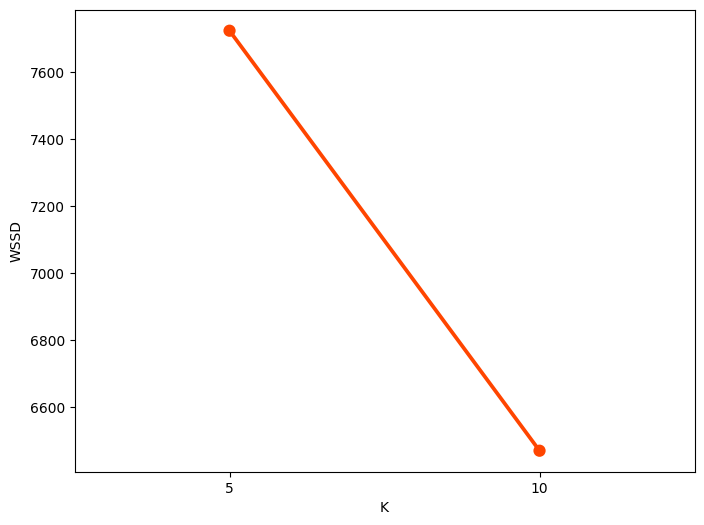

In [ ]:
plot_clustering_results(clustering_results)

In [ ]:
K=10 # Best value of K (whatever this is!)
print("Running K-means using K = {:d}".format(K))
model, clusters_df = k_means(tf_idf_df, K, max_iter=50, distance_measure="cosine")
clusters_df.cache()

Running K-means using K = 10
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  


DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>, tf_features: vector, features: vector, features_norm: vector, cluster: int]

### Inspect some clusters

In [ ]:
clusters_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 1156|
|      1| 4183|
|      2|  321|
|      3| 1567|
|      4|  614|
|      5| 1096|
|      6| 1379|
|      7|  669|
|      8| 1370|
|      9| 1692|
+-------+-----+



In [ ]:
# Get unique values in the grouping column
clusters = sorted([x[0] for x in clusters_df.select("cluster").distinct().collect()])
print("Cluster IDs: [{:s}]".format(", ".join([str(c) for c in clusters])))

# Create a filtered DataFrame for each group in a list comprehension
cluster_list = [clusters_df.where(clusters_df.cluster == x) for x in clusters]

# Show the results
for x_id, x in enumerate(cluster_list):
  print("Showing the first 20 records of cluster ID #{:d}".format(x_id))
  x.select(["cluster", "Job title", "Salary range", "Location", "Tier", "Experience requirement", "Education requirements"]).show(20, truncate=False)

Cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Showing the first 20 records of cluster ID #0
+-------+---------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------------+----------------------+
|cluster|Job title                                                                              |Salary range|Location |Tier                 |Experience requirement |Education requirements|
+-------+---------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------------+----------------------+
|0      |big data statistics assistant wrapdouble break                                         |(B)[4K-8K)  |Shenzhen |First-tier cities    |(C)Experience unlimited|(B)Secondary Education|
|0      |data entry clerk                                                                       |(B)[4K-8K)  |Tianjin  |New first-tier cities|(C)Exper

# **Cluster Data Analysis**



### Show the first 10 most frequently occuring terms in each cluster [5 Marks]

In [ ]:

for x_id, x in enumerate(cluster_list):
  print(f'Showing the highest 10 frequency terms for Cluster {x_id}')

  #Explode the terms column to create individual rows for each term:
  # exploded_df = x.select(explode("terms").alias("words"))
  # exploded_df.groupBy('words').count().sort('count',ascending=False).show(10)

  x.createOrReplaceTempView("terms_table")

  result = spark.sql("""
      SELECT words, COUNT(*) as count
      FROM (
          SELECT explode(terms) as words
          FROM terms_table
      )
      GROUP BY words
      ORDER BY count DESC
      limit 10
  """).show()

Showing the highest 10 frequency terms for Cluster 0
+----------+-----+
|     words|count|
+----------+-----+
|      data|  787|
|     clerk|  423|
|       one|  258|
|     entry|  219|
|     break|  205|
| insurance|  184|
|    double|  182|
|      gold|  181|
|         k|  180|
|statistics|  159|
+----------+-----+

Showing the highest 10 frequency terms for Cluster 1
+-----------+-----+
|      words|count|
+-----------+-----+
|       data| 3335|
|   engineer| 2979|
|development| 1618|
|        big| 1608|
|  operation|  367|
|     senior|  274|
|  architect|  202|
|   database|  187|
|  warehouse|  178|
| operations|  140|
+-----------+-----+

Showing the highest 10 frequency terms for Cluster 2
+-----------+-----+
|      words|count|
+-----------+-----+
|   software|  205|
|   engineer|  185|
|       data|  157|
|       test|  127|
|development|   72|
|        big|   63|
|    manager|   29|
|       java|   29|
|      sales|   28|
|     senior|   22|
+-----------+-----+

Showing the 

### Salary range analysis of jobs according to city tier system [5 Marks]

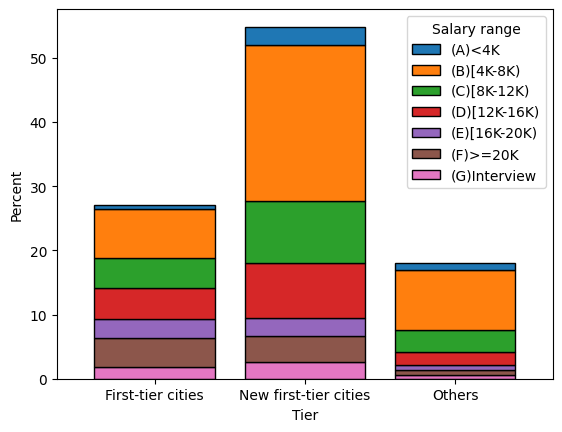

In [ ]:

df_pandas = clusters_df.toPandas()
df_counts = df_pandas.groupby('Tier')['Salary range'].value_counts().unstack().fillna(0)
total = df_counts.sum().sum()
df_counts = df_counts / total * 100
df_counts = df_counts.iloc[:, ::-1]

num_categories = len(df_counts.columns)
colors = sns.color_palette("tab10", num_categories)
ax =df_counts.plot(kind='bar', stacked=True, color= colors[::-1],edgecolor='black',width=0.8)

plt.xlabel('Tier')
plt.ylabel('Percent')
plt.xticks(rotation='horizontal')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Salary range', loc='upper right')

plt.show()

<!-- ### Proportions of jobs available in each cluster [5 Marks] -->

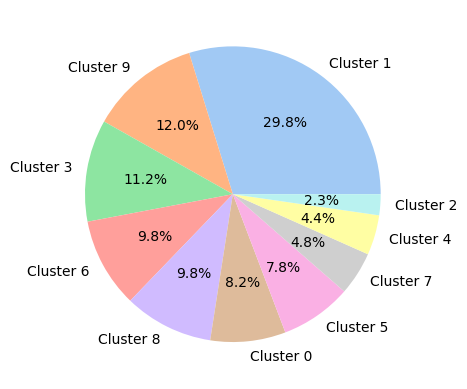

In [ ]:

data = clusters_df.groupBy('cluster').count().sort('count',ascending=False)
pandas_df = data.toPandas()
clusters = pandas_df['cluster'].tolist()
count = pandas_df['count'].tolist()

clusters = [f"Cluster {i}" for i in clusters]
palette_color = sns.color_palette('pastel')


plt.pie(count, labels=clusters,colors=palette_color, autopct='%1.1f%%')
plt.show()


### Education requirements analysis of jobs in each cluster [5 Marks]

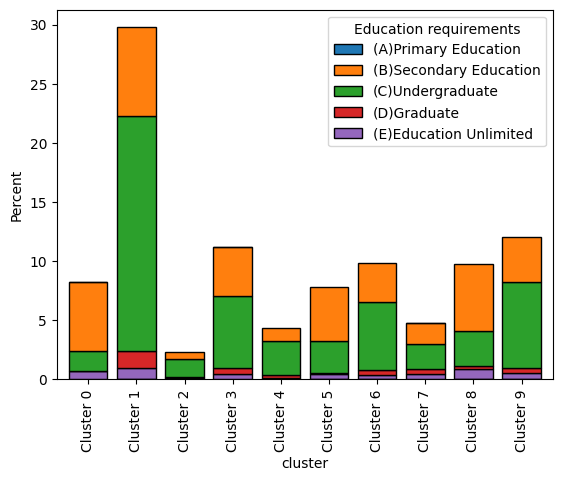

In [ ]:

df_pandas = clusters_df.toPandas()
df_pandas['cluster'] = df_pandas['cluster'].apply(lambda x:'Cluster '+str(x) )
df_counts = df_pandas.groupby('cluster')['Education requirements'].value_counts().unstack().fillna(0)
total = df_counts.sum().sum()
df_counts = df_counts / total * 100
df_counts = df_counts.iloc[:,::-1]

num_categories = len(df_counts.columns)
colors = sns.color_palette("tab10", num_categories)
ax =df_counts.plot(kind='bar', stacked=True, edgecolor='black', color=colors[::-1],width=0.8)

plt.xlabel('cluster')
plt.ylabel('Percent')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Education requirements', loc='upper right')
plt.show()

### Experience requirements analysis of jobs in each cluster [5 Marks]

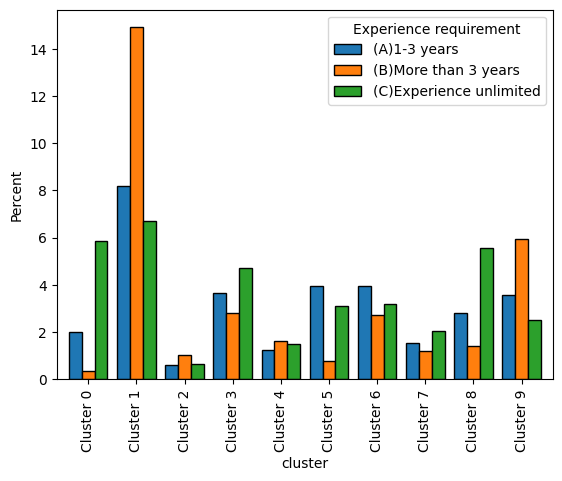

In [ ]:

df_pandas = clusters_df.toPandas()
df_pandas['cluster'] = df_pandas['cluster'].apply(lambda x:'Cluster '+str(x) )
df_counts = df_pandas.groupby('cluster')['Experience requirement'].value_counts().unstack().fillna(0)
total = df_counts.sum().sum()
df_counts = df_counts / total * 100

colors = sns.color_palette()
ax =df_counts.plot(kind='bar', stacked=False, edgecolor='black', color=colors,width=0.8)

plt.xlabel('cluster')
plt.ylabel('Percent')

plt.show()

### Why do you think the majority of job adverts falling in Cluster 1 and Cluster 9 require `More than 3 years` experience? Provide your answer here. [10 Marks]

This can be seen by the graph above of education requirements of jobs in each cluster. Its can be seen that cluster one has the highest percent of jobs adverts that require higher levels of education such as an undergraduate degree. This is followed by cluster nine with the second highest percent of higher-level education requirements. These jobs typically require more skill and are more complex than those that only require a primary education. Furthermore, due to the difficult nature of these jobs, typically they require a couple years of experience in order to cater for this difficulty and to master the jobs requirements.  

It can be seen how different job adverts have varying education requirements and experience requirements. Cluster nine contains job adverts that typically require bachelor’s degrees and more than 3 years of experience. Scanning the data in cluster one and cluster nine, jobs such as a product manager, advanced data operator and senior data administrator can be found. These jobs typically have higher rank in the company, and thus it is expected to have higher education requirements and experience requirements. Compared to cluster 8, which typically has sales related jobs. These jobs generally have lower education requirements and have higher acceptance of college degrees. than those in cluster one and cluster nine. However, with more than 3 years of experience there are more opportunities as seen by the large result in the experience unlimited bar.

Thus, cluster one and cluster nine highlights how more challenging, complex and more executive jobs, such as a senior data analyst, have more-demanding requirements such as higher education qualifications



### Salary range analysis of jobs in each cluster [5 Marks]

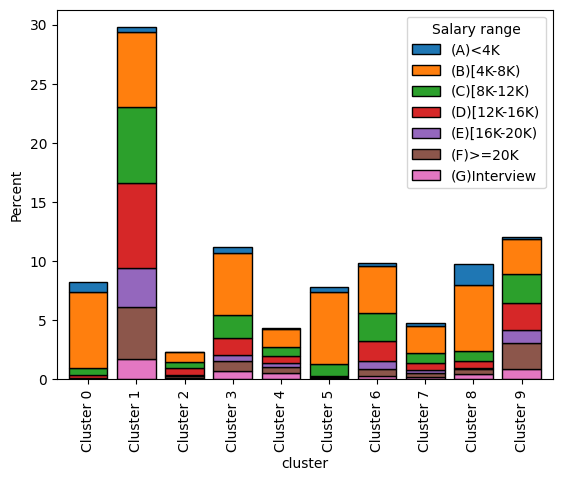

In [ ]:

df_pandas = clusters_df.toPandas()
df_pandas['cluster'] = df_pandas['cluster'].apply(lambda x:'Cluster '+str(x) )
df_counts = df_pandas.groupby('cluster')['Salary range'].value_counts().unstack().fillna(0)
total = df_counts.sum().sum()
df_counts = df_counts / total * 100
df_counts = df_counts.iloc[:, ::-1]

num_categories = len(df_counts.columns)
colors = sns.color_palette("tab10", num_categories)
ax = df_counts.plot(kind='bar', stacked=True, edgecolor='black', color=colors[::-1],width=0.8)

plt.xlabel('cluster')
plt.ylabel('Percent')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Salary range', loc='upper right')
plt.show()

### Why do you think that jobs in Cluster 1 and Cluster 9 have a higher salary range compared to other clusters? Please provide your answer here. [10 Marks]

As mentioned above, clusters one and cluster nine have the highest requirement for higher levels of education such as an undergraduate degree and above. Majority of these jobs in these clusters also require more than 3 years’ experience. This is due to these jobs being more executive, complex and challenging. Such jobs in these clusters are data engineers, and big data operation engineer. Thus, there is a higher salary for these jobs. Clusters nine and one have the largest portion of salaries in the highest range, which is above 20k. Furthermore, due to the higher requirements and expertise required, these jobs typically have very few qualified applicants who are skilled enough as well as have fewer available positions. These senior jobs are in demand in first-tier cities, yet there is a lack of supply of these advanced skills, and as such this drives the salary of these jobs higher.

Furthermore, earlier graph of the tier vas the salary highlights how most of the higher salary ranges occur in the ‘first -tier’ cities and the ‘new first-tier cities’. Due to most of the job adverts in clusters one and nine being in these cities, the salaries are generally higher as there is much higher economic development and innovation.


### Please critically evaluate the performance of the implementation of the K-means text clustering method in this notebook and provide suggestions for enhancing its performance. You are not required to implement your suggestions. Please provider your answer here. [10 Marks]

The silhouette coefficient for K=10 was 0.238 which is a moderate level of clustering as considering no hyperparameter tuning. The closer to 1 means the more distinct the clusters are.This means that the clusters arent perfectly distinct, and there portions of misclassification. Thus the silhouette coefficient should be reduced to enable better clustering ability.

The reported WCSS of 6469.251. The lower the WCSS, the better the clustering and the clusters become more comapct and distinct. This value is also moderate, but is massively improved due to the data preprocessing


**Improvements** :

*  Experimenting with different number of clusters. This can be done for random values or using an iterative approach. Then the optimal number of clusters can be determined which will improve the performance
*  Plot the clusters and perform analysis of outliers and misclassifications, also known as exploratory data analysis. Then change the clustering parameters and/or change the data preprocessing accordingly
* Use a different distance metric to perform the clustering
* Experiment with different feature representations such as word embeddings or topic models to capture more meaning from the data
* Perform hyperparameter tuning (convergence criteria, learning rate etc.) using random search to find the best combination of parameters that maximises performance.
* Explore if performing more iterations of the clustering algorithm improves performance until what number of iterations which is computationally feasible
* Use different initialisation techniques such as mini-batch K-means or K-means++ which can improve efficiency of convergence and potentially lead to improved clustering results



